In [1]:
from explainers.GNNBoundary.gnn_boundary.models.gcn_classifier import GCNClassifier as GCNClassifier
import torch as torch

In [2]:
import numpy as np

In [3]:

model = GCNClassifier(num_layers=3, num_classes=2, node_features=3, hidden_channels=16)
model.load_state_dict(torch.load('model/report_models/grids.pt'))

<All keys matched successfully>

In [4]:
from graph_generation.GridGraphs import GridGraphs
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(GridGraphs(5000).getDataset())
mean_embeds = dataset.mean_embeddings(model)


/home/sobibence/AAU/2_semester/project/GraBaNN/libraries/dataLoaderWrapper.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obj.y = torch.tensor(obj.y, dtype=torch.long)


In [5]:
y = [data.y for data in dataset]
classes = np.unique(y)
class_indexes = []
for c in classes:
    class_indexes.append(np.where(y == c)[0])
class_indexes

[array([   1,    3,    5, ..., 4995, 4997, 4999]),
 array([   0,    2,    4, ..., 4994, 4996, 4998])]

In [6]:

trainers = {}

In [10]:
from explainers.gnninterpreter import *
c = 0

trainers[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=5,
                num_node_cls=3,
                temperature=0.15,
                learn_node_feat=True
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=5),
                #dict(key="logits", criterion=ClassScoreCriterion(class_idx=, mode='minimize'), weight=5),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=5),
                dict(key="logits", criterion=MeanPenalty(), weight=0),
                dict(key="omega", criterion=NormPenalty(order=1), weight=1),
                dict(key="omega", criterion=NormPenalty(order=2), weight=1),
                dict(key="xi", criterion=NormPenalty(order=1), weight=0),
                dict(key="xi", criterion=NormPenalty(order=2), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=16
        )
trainers[c].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

True

n=4 m=3
logits=[-2.412457227706909, 3.876957416534424]
probs=[0.0018524086335673928, 0.9981476068496704]


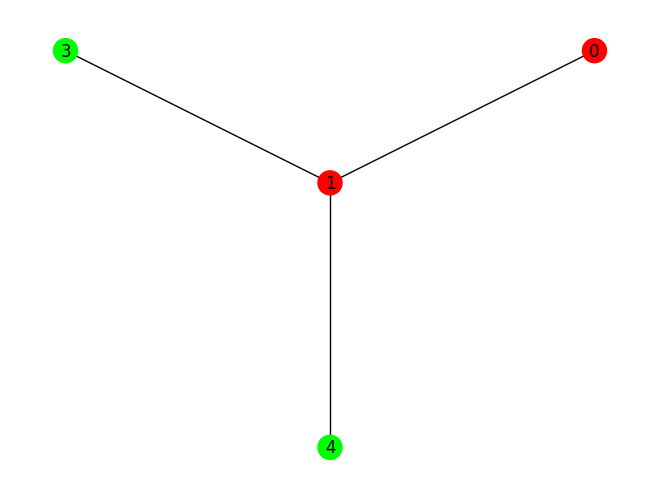

(<networkx.classes.graph.Graph at 0x7f77401a3a00>,
 {'n': 4,
  'm': 3,
  'logits': [-2.412457227706909, 3.876957416534424],
  'probs': [0.0018524086335673928, 0.9981476068496704]})

In [8]:
trainers[1].evaluate(threshold=0.5, show=True)

n=5 m=5
logits=[3.7294678688049316, -3.335620164871216]
probs=[0.9991463422775269, 0.0008536900859326124]


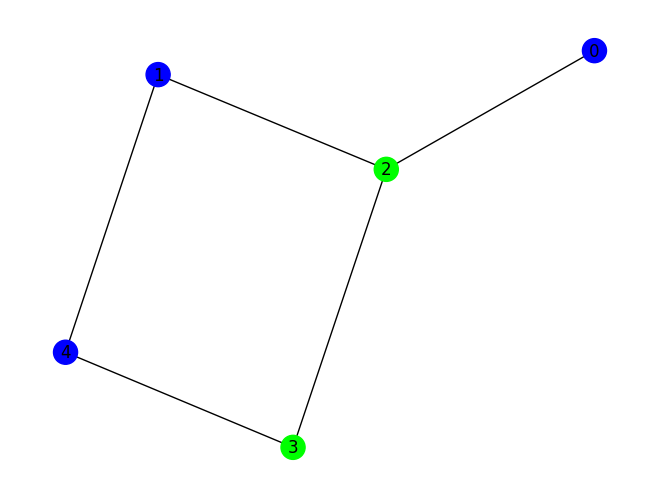

(<networkx.classes.graph.Graph at 0x7f7741be4160>,
 {'n': 5,
  'm': 5,
  'logits': [3.7294678688049316, -3.335620164871216],
  'probs': [0.9991463422775269, 0.0008536900859326124]})

In [11]:
trainers[0].evaluate(threshold=0.5, show=True)